In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib.patches import Rectangle
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

# UPLOAD DATASET

In [3]:
data = pd.read_csv("/kaggle/input/tyres-train/tyres_train.csv", sep = ",")

data.head(10)

,vulc,perc_nat_rubber,wiring_strength,weather,perc_imp,temperature,tread_type,tyre_season,elevation,month,tread_depth,tyre_quality,perc_exp_comp,diameter,add_layers,failure
0,17.990,26,1,0.16,0.01,-8.12,0,1,332.5,8,0,1,5.13,55.0,1,0
1,20.704,36,1,0.30,0.01,-4.52,2,0,328.0,11,1,0,6.15,NaN,1,0
2,19.156,34,1,0.30,0.01,-1.08,0,0,247.0,0,1,0,6.36,NaN,1,0
3,16.802,35,1,0.19,0.02,7.44,1,0,408.0,7,3,1,6.62,54.5,1,0
4,17.140,23,2,0.39,0.01,30.52,0,1,308.0,2,2,0,6.15,76.3,1,0
5,20.042,38,0,0.04,0.01,-0.20,2,1,160.5,0,0,0,5.96,NaN,1,0
6,21.172,33,1,0.39,0.01,-2.28,0,0,470.0,3,0,0,6.47,NaN,1,0
7,16.706,32,0,0.62,0.05,-3.96,3,1,148.5,7,2,0,5.39,NaN,1,0
8,17.616,25,1,0.16,0.01,-6.88,0,1,103.5,8,0,1,5.32,63.6,1,0
9,17.370,34,0,0.27,0.01,-1.28,2,0,345.5,5,2,0,6.31,NaN,0,0


# DATA OBSERVATION AND PREPARATION

In [4]:
data.dtypes
# categorical variables are no "object" type

vulc               float64
perc_nat_rubber      int64
wiring_strength      int64
weather            float64
perc_imp           float64
temperature        float64
tread_type           int64
tyre_season          int64
elevation          float64
month                int64
tread_depth          int64
tyre_quality         int64
perc_exp_comp      float64
diameter           float64
add_layers           int64
failure              int64
dtype: object

In [5]:
data.isnull().sum()
# the variable "diameter" is almost empty --> impossible to proceed with substitution

vulc                  0
perc_nat_rubber       0
wiring_strength       0
weather               0
perc_imp              0
temperature           0
tread_type            0
tyre_season           0
elevation             0
month                 0
tread_depth           0
tyre_quality          0
perc_exp_comp         0
diameter           2110
add_layers            0
failure               0
dtype: int64

Through the observation of the dataset we can see that most of the data don't have a numeric value in the column "diameter". For this reason, we have decided to crop that column as it does not provide any relevant information

In [6]:
#dropping all column "diameter"
d="diameter"
data_dropped = data.drop(columns=d)

data_dropped.head()

,vulc,perc_nat_rubber,wiring_strength,weather,perc_imp,temperature,tread_type,tyre_season,elevation,month,tread_depth,tyre_quality,perc_exp_comp,add_layers,failure
0,17.990,26,1,0.16,0.01,-8.12,0,1,332.5,8,0,1,5.13,1,0
1,20.704,36,1,0.30,0.01,-4.52,2,0,328.0,11,1,0,6.15,1,0
2,19.156,34,1,0.30,0.01,-1.08,0,0,247.0,0,1,0,6.36,1,0
3,16.802,35,1,0.19,0.02,7.44,1,0,408.0,7,3,1,6.62,1,0
4,17.140,23,2,0.39,0.01,30.52,0,1,308.0,2,2,0,6.15,1,0


In [7]:
data_dropped.isnull().sum()
# no more NaN observations

vulc               0
perc_nat_rubber    0
wiring_strength    0
weather            0
perc_imp           0
temperature        0
tread_type         0
tyre_season        0
elevation          0
month              0
tread_depth        0
tyre_quality       0
perc_exp_comp      0
add_layers         0
failure            0
dtype: int64

failure
0    1992
1    1008
dtype: int64


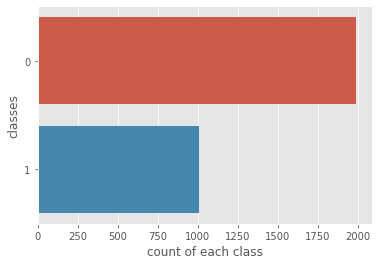

In [8]:
print(data_dropped.groupby('failure').size())

%matplotlib inline
plt.style.use('ggplot')

#Visualize Class Counts
sns.countplot(y=data_dropped.failure ,data=data_dropped)
plt.xlabel("count of each class")
plt.ylabel("classes")
plt.show()
# the dataset is unbalanced --> we will try to perform oversampling on the training set

## Categorical variables

In [9]:
selection_categorical=['tread_type', 'tyre_season','month', 'tread_depth', 'wiring_strength', 'tyre_quality',
       'add_layers']
data_categorical=data_dropped[selection_categorical]
data_categorical.head()

,tread_type,tyre_season,month,tread_depth,wiring_strength,tyre_quality,add_layers
0,0,1,8,0,1,1,1
1,2,0,11,1,1,0,1
2,0,0,0,1,1,0,1
3,1,0,7,3,1,1,1
4,0,1,2,2,2,0,1


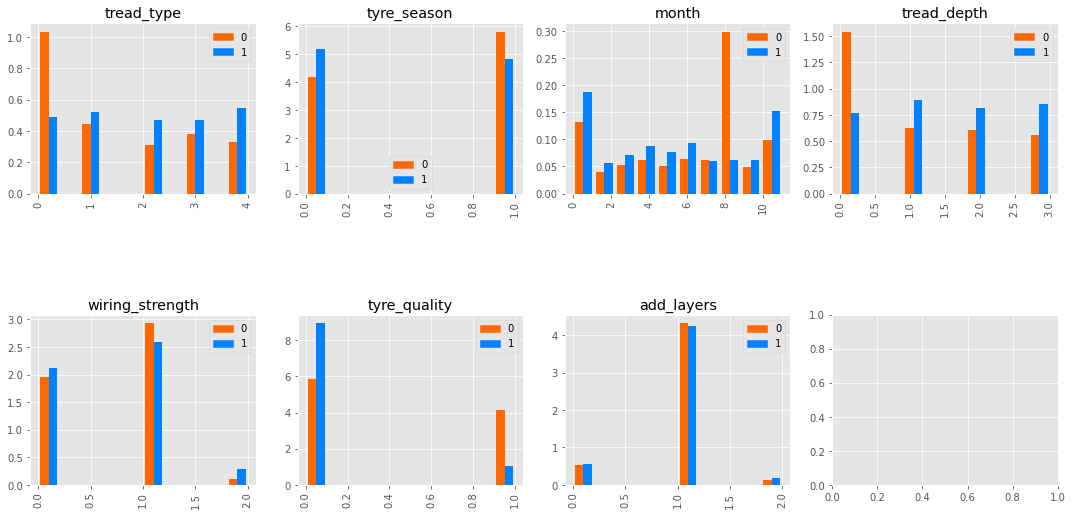

In [10]:
# Visualize categorical variables
data_0=data_categorical[data_dropped['failure']==0] # records wih target==0
data_1=data_categorical[data_dropped['failure']==1] # records wih target==1

cmap = plt.get_cmap('jet')
col=[cmap(0.8),cmap(0.25)]
fig, axes = plt.subplots(2, 4,figsize=[15,7])
axes = axes.flatten()
fig.tight_layout(h_pad=10)

i=0
for x in data_categorical.columns:
    plt.sca(axes[i]) # set the current Axes
    plt.hist([data_0[x],data_1[x]],density=True,color=col)
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    plt.title(x)
    handles = [Rectangle((0,0),1,1,color=c)for c in col]
    labels= ["0","1"]
    plt.legend(handles, labels)
    i+=1
plt.show()

The dataset is not only composed of numerical attributes but also by categorical ones. Plotting each histogram to analyze their distribution it's possible to observe that the attribute "add_layers" has always the same distibution on target 0 and 1. Following this consideration we took the decision of removing that attribute too.

In [11]:
ad="add_layers"
data_categorical = data_categorical.drop(columns=ad)
selection_categorical = ['tread_type', 'tyre_season', 'tread_depth','month', 'wiring_strength', 'tyre_quality']

### Create dummies with the OneHotEncoder method

Our categorical attributes are represented by numbers but in order to have them with the same weight we have found reasonable to create dummies and represent everything with the values 0 and 1. We have chosen the OneHotEncoder method since this saves the exploded categories into its object.

In [12]:
from sklearn.preprocessing import OneHotEncoder
encod = OneHotEncoder(handle_unknown='ignore')

data_dummies=pd.DataFrame()
for i in range(len(selection_categorical)):
    encod.fit(data_dropped[[selection_categorical[i]]].astype(str))
    dummies = encod.transform(data_dropped[[selection_categorical[i]]].astype(str)).toarray()
    for k in range(len(encod.categories_[0])):
        encod.categories_[0][k]=selection_categorical[i]+"_"+str(encod.categories_[0][k])
    data_dummies=pd.concat([data_dummies,pd.DataFrame(dummies,columns=encod.categories_[0])],axis=1)
    
data_dummies.head()

,tread_type_0,tread_type_1,tread_type_2,tread_type_3,tread_type_4,tyre_season_0,tyre_season_1,tread_depth_0,tread_depth_1,tread_depth_2,...,month_5,month_6,month_7,month_8,month_9,wiring_strength_0,wiring_strength_1,wiring_strength_2,tyre_quality_0,tyre_quality_1
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


## Numerical Variables

In [13]:
selection_numerical=['vulc', 'perc_nat_rubber', 'weather', 'perc_imp', 'temperature', 'elevation',
       'perc_exp_comp','failure']
data_numerical=data_dropped[selection_numerical]
data_numerical.head()

,vulc,perc_nat_rubber,weather,perc_imp,temperature,elevation,perc_exp_comp,failure
0,17.990,26,0.16,0.01,-8.12,332.5,5.13,0
1,20.704,36,0.30,0.01,-4.52,328.0,6.15,0
2,19.156,34,0.30,0.01,-1.08,247.0,6.36,0
3,16.802,35,0.19,0.02,7.44,408.0,6.62,0
4,17.140,23,0.39,0.01,30.52,308.0,6.15,0


(1992, 8)
(1008, 8)


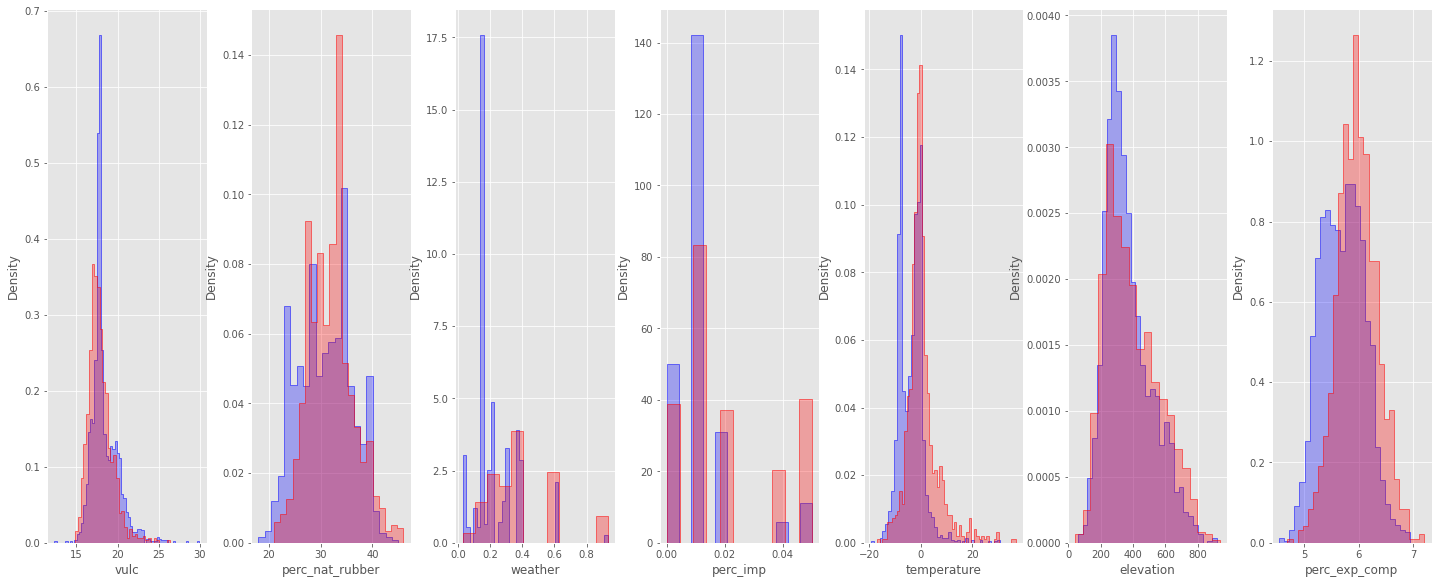

In [14]:
# Visualize numerical variables
X0 = data_numerical[data_numerical['failure']==0]
X1 = data_numerical[data_numerical['failure']==1]
print(X0.shape)
print(X1.shape)
fig, axes = plt.subplots(ncols=7, nrows=1, figsize=(20,8))
fig.tight_layout()

data_num = data_numerical.iloc[:,0:-1]

for i, ax in zip(range(data_num.columns.size), axes.flat):
    sns.histplot(X0.iloc[:,i], color="blue", ax=ax, stat='density', element="step",  alpha=0.3)
    sns.histplot(X1.iloc[:,i], color="red", ax=ax,stat='density', element="step",  alpha=0.3)
plt.show()


Studying the distribution of numerical attributes, we have noticed that "elevation" variable has the same distibution on target 0 and 1 as well as "add_layers" explained before. Thus, we find reasonable to eliminate it since we do not find it significant for the analysis

In [15]:
e = "elevation"
data_numerical = data_numerical.drop(columns=e)

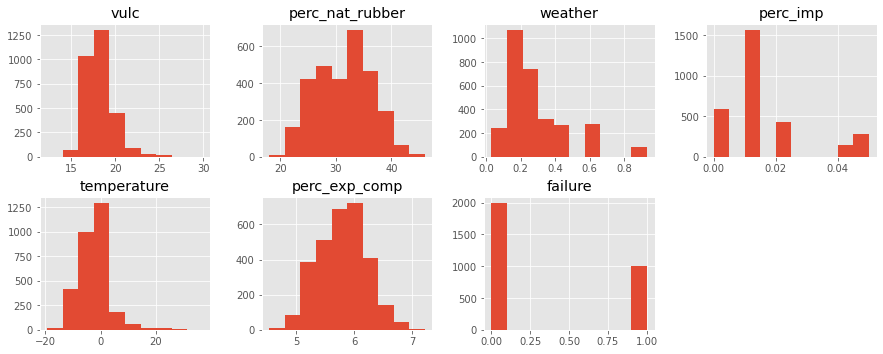

In [16]:
data_hist = data_numerical.hist(layout=(4,4), figsize=(15,12))
# no exponential variable to normalize

<AxesSubplot:>

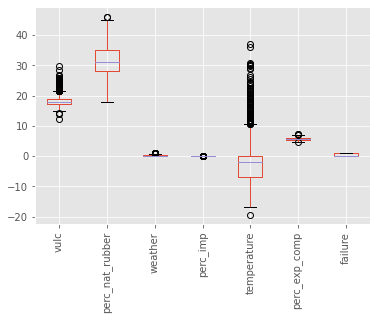

In [17]:
data_numerical.boxplot(rot=90)

Since the scale of numerical variables is too different, we will scale the train set and apply the same scaler on the test set after the split of the dataset

In [18]:
# Create final dataset with all modifications and target variable included
#print(K)

df=pd.concat([data_dummies,data_numerical],axis=1)

#df.drop(K,axis=0,inplace=True)

df['failure']=data_dropped['failure']


df.tail()

,tread_type_0,tread_type_1,tread_type_2,tread_type_3,tread_type_4,tyre_season_0,tyre_season_1,tread_depth_0,tread_depth_1,tread_depth_2,...,wiring_strength_2,tyre_quality_0,tyre_quality_1,vulc,perc_nat_rubber,weather,perc_imp,temperature,perc_exp_comp,failure
2995,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,17.818,29,0.39,0.01,7.28,5.68,1
2996,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,17.076,30,0.22,0.00,-1.44,5.81,1
2997,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,16.170,33,0.39,0.01,-3.44,5.57,0
2998,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,18.872,37,0.03,0.00,-0.76,5.89,0
2999,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,20.272,33,0.06,0.00,2.80,6.00,0


# Creation of Train and Test Sets

In [19]:
X = df.iloc[:,0:-1]
y = df.iloc[:,-1] #[-1]]

In [20]:
#SPLIT DATA INTO TRAIN AND TEST SET
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, 
                                                    test_size =0.20, 
                                                    #shuffle is set True by default,
                                                    stratify=y, #preserve target proportions 
                                                    random_state= 42) 

print(X_train1.shape, X_test1.shape)

(2400, 34) (600, 34)


Selecting the numerical variables in the train set only, we scale them and, saving the scaler, we will apply it to the numerical variables of the test set.

In [21]:
numerical=['vulc','perc_nat_rubber', 'weather', 'perc_imp', 'temperature', 'perc_exp_comp']


independent_variablesA=X_train1[numerical] #no target
independent_variablesB=X_test1[numerical] #no target

scaler_train = StandardScaler().fit(independent_variablesA) 
scaled_train = pd.DataFrame(scaler_train.transform(independent_variablesA))
scaled_train.columns = independent_variablesA.columns

scaled_test = pd.DataFrame(scaler_train.transform(independent_variablesB))
scaled_test.columns = independent_variablesB.columns
print(scaled_test.shape, scaled_train.shape)
scaled_test.head(10)

(600, 6) (2400, 6)


,vulc,perc_nat_rubber,weather,perc_imp,temperature,perc_exp_comp
0,-0.299530,-1.644094,-0.656931,-0.316066,-0.877116,-1.436695
1,-0.266915,-1.241992,1.828084,2.514375,1.782521,1.039006
2,-0.312074,-1.241992,-0.656931,-0.316066,-0.945488,-1.703683
3,-0.818857,0.969568,0.585577,-0.316066,0.339890,1.184635
4,-0.461349,-1.040941,0.585577,-0.316066,0.025383,-0.708548
5,-0.217993,-1.241992,-0.656931,-0.316066,-1.034370,-0.902721
6,-1.521328,1.773772,3.502768,1.806765,1.078299,2.252585
7,-0.151509,-1.443043,-0.656931,-0.316066,-1.061719,-1.752226
8,0.714036,0.969568,-1.305195,-0.316066,0.189474,0.820561
9,-0.663310,-0.638839,0.477532,0.391544,2.103866,2.592387


<AxesSubplot:>

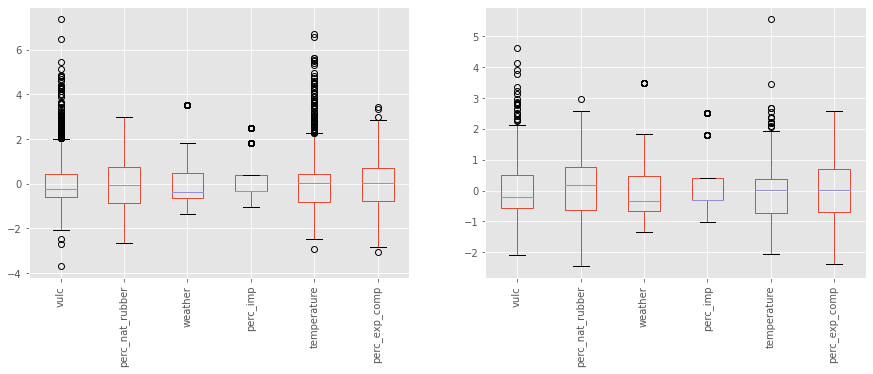

In [22]:
f, axes = plt.subplots(1, 2, figsize=(15,5))

scaled_train.boxplot(rot=90,ax=axes[0])
scaled_test.boxplot(rot=90,ax=axes[1])
# the two sets are scaled correctly

In [23]:
scaled_train.index= independent_variablesA.index
scaled_test.index= independent_variablesB.index

train_dropped = X_train1.drop(columns=numerical)
test_dropped = X_test1.drop(columns=numerical)
print(test_dropped.shape, train_dropped.shape)

Xtrain2=pd.concat([train_dropped,scaled_train],axis=1)
Xtest2=pd.concat([test_dropped,scaled_test],axis=1)


(600, 28) (2400, 28)


In [24]:
# check correct substitution
print(Xtest2.isnull().sum(), '\n\n\n', Xtrain2.isnull().sum())

tread_type_0         0
tread_type_1         0
tread_type_2         0
tread_type_3         0
tread_type_4         0
tyre_season_0        0
tyre_season_1        0
tread_depth_0        0
tread_depth_1        0
tread_depth_2        0
tread_depth_3        0
month_0              0
month_1              0
month_10             0
month_11             0
month_2              0
month_3              0
month_4              0
month_5              0
month_6              0
month_7              0
month_8              0
month_9              0
wiring_strength_0    0
wiring_strength_1    0
wiring_strength_2    0
tyre_quality_0       0
tyre_quality_1       0
vulc                 0
perc_nat_rubber      0
weather              0
perc_imp             0
temperature          0
perc_exp_comp        0
dtype: int64 


 tread_type_0         0
tread_type_1         0
tread_type_2         0
tread_type_3         0
tread_type_4         0
tyre_season_0        0
tyre_season_1        0
tread_depth_0        0
tread_depth_1    

In [25]:
# create new scaled datasets
df_train=pd.concat([Xtrain2,y_train1],axis=1)
df_test=pd.concat([Xtest2,y_test1], axis=1)

df_test.head(10)

,tread_type_0,tread_type_1,tread_type_2,tread_type_3,tread_type_4,tyre_season_0,tyre_season_1,tread_depth_0,tread_depth_1,tread_depth_2,...,wiring_strength_2,tyre_quality_0,tyre_quality_1,vulc,perc_nat_rubber,weather,perc_imp,temperature,perc_exp_comp,failure
2448,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,-0.299530,-1.644094,-0.656931,-0.316066,-0.877116,-1.436695,0
982,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,-0.266915,-1.241992,1.828084,2.514375,1.782521,1.039006,1
773,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,-0.312074,-1.241992,-0.656931,-0.316066,-0.945488,-1.703683,0
901,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.818857,0.969568,0.585577,-0.316066,0.339890,1.184635,1
399,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,-0.461349,-1.040941,0.585577,-0.316066,0.025383,-0.708548,1
2297,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,-0.217993,-1.241992,-0.656931,-0.316066,-1.034370,-0.902721,0
1615,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-1.521328,1.773772,3.502768,1.806765,1.078299,2.252585,1
2109,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,-0.151509,-1.443043,-0.656931,-0.316066,-1.061719,-1.752226,0
1042,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.714036,0.969568,-1.305195,-0.316066,0.189474,0.820561,0
17,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,-0.663310,-0.638839,0.477532,0.391544,2.103866,2.592387,1


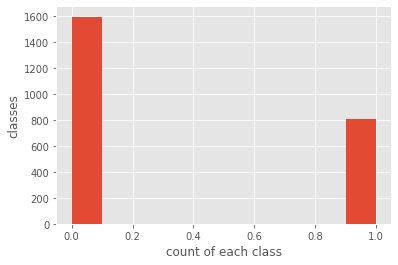

0    1594
1     806
Name: failure, dtype: int64

In [26]:
plt.hist(y_train1)
plt.xlabel("count of each class")
plt.ylabel("classes")
plt.show()
df_train.failure.value_counts()
# the dataset is unbalanced --> we can try to perform oversampling on target 1 to see if the F1 score gets better during identificaiton of the model

In [27]:
#resample train set
df_majority = df_train[df_train.failure==0]
df_minority = df_train[df_train.failure==1] 
print(df_majority.shape[0],df_minority.shape[0])

df_minority_overs = resample(df_minority, 
                                replace=True,
                                n_samples=1200,     
                                random_state=42)  

df_overs_train = pd.concat([df_minority_overs, df_majority])

df_overs_train.failure.value_counts()


1594 806


0    1594
1    1200
Name: failure, dtype: int64

In [28]:
#from sklearn.utils import shuffle
#df_oversampled_train = shuffle(df_oversampled_train)

In [29]:
#Separate X and y on the new DataFrames
# Dataframes with oversample
X2_train=df_overs_train.iloc[:,0:-1]
y2_train=df_overs_train.iloc[:,-1]

#DataFrames without oversample
X_train=df_train.iloc[:,0:-1]
y_train=df_train.iloc[:,-1]

X_test = df_test.iloc[:,0:-1]
y_test = df_test.iloc[:,-1]

print(X2_train.shape,X_train.shape,X_test.shape)

(2794, 34) (2400, 34) (600, 34)


# Models 

## Needed functions 

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics 
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

In [31]:
def hyperp_search(classifier, parameters):
    gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=0, n_jobs=-1)
    gs = gs.fit(X_train, y_train)
    print("f1_train: %f using %s" % (gs.best_score_, gs.best_params_))

    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    print("f1         train %.3f   test %.3f" % (f1_score(y_train, y_pred_train), f1_score(y_test, y_pred)))
    print("precision  train %.3f   test %.3f" % (precision_score(y_train, y_pred_train), precision_score(y_test, y_pred) )) 
    print("")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
 

In [32]:
def hyperp_search_over(classifier, parameters):
    gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=0, n_jobs=-1)
    gs = gs.fit(X2_train, y2_train)
    print("f1_train: %f using %s" % (gs.best_score_, gs.best_params_))

    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X2_train)

    print("f1         train %.3f   test %.3f" % (f1_score(y2_train, y_pred_train), f1_score(y_test, y_pred)))
    print("precision  train %.3f   test %.3f" % (precision_score(y2_train, y_pred_train), precision_score(y_test, y_pred) )) 
    print("")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
 

In [33]:
def roc(model,X_train,y_train,X_test,y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_probs = model.predict_proba(X_test)

    fpr, tpr, thresholds1=metrics.roc_curve(y_test,  y_probs[:,1])

    import matplotlib.pyplot as plt
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    auc = metrics.roc_auc_score(y_test, y_probs[:,1])
    print('AUC: %.2f' % auc)
    return (fpr, tpr)

## Research of the best model

For each model we compared the results obtained through the application of the oversample to the train set of the dataset and the ones obtained without oversampling.
We thought to apply the oversample to the train set because we have a strong difference between the number of success (1594) and the number of failure (806). 

### TREE

In [58]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
parameters = {'criterion': ['gini','entropy'], 
              'max_depth': [2,3,4],
              'min_samples_split': [2,4,6,8,12,16,18,20],
              'min_samples_leaf': [4,6,8,12,16,18,20]}

In [60]:
#Results of the parameters without the use of oversample  
hyperp_search(classifier,parameters)

f1_train: 0.533125 using {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 12, 'min_samples_split': 2}
f1         train 0.631   test 0.596
precision  train 0.677   test 0.620

[[327  71]
 [ 86 116]]
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       398
           1       0.62      0.57      0.60       202

    accuracy                           0.74       600
   macro avg       0.71      0.70      0.70       600
weighted avg       0.73      0.74      0.74       600



In [61]:
#Results of the parameters using oversample  
hyperp_search_over(classifier,parameters)

f1_train: 0.697806 using {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 16, 'min_samples_split': 2}
f1         train 0.708   test 0.611
precision  train 0.639   test 0.508

[[248 150]
 [ 47 155]]
              precision    recall  f1-score   support

           0       0.84      0.62      0.72       398
           1       0.51      0.77      0.61       202

    accuracy                           0.67       600
   macro avg       0.67      0.70      0.66       600
weighted avg       0.73      0.67      0.68       600



In [63]:
model_Tree= DecisionTreeClassifier(criterion= 'gini', max_depth= 4, min_samples_leaf= 12, min_samples_split= 2)
model_Tree_over= DecisionTreeClassifier(criterion= 'gini', max_depth= 3, min_samples_leaf= 16, min_samples_split= 2)

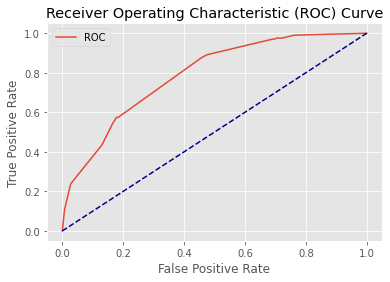

AUC: 0.79


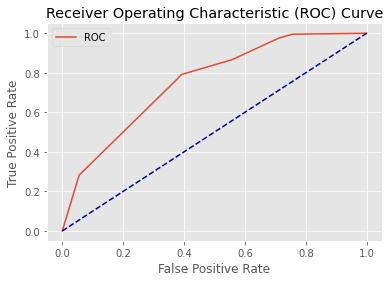

AUC: 0.75


In [64]:
#curva ROC
fpr1,tpr1=roc(model_Tree,X_train,y_train,X_test,y_test) # no oversample
fpr2,tpr2=roc(model_Tree_over,X2_train,y2_train,X_test,y_test) # oversample

#### Plotting tree

In [65]:
from sklearn import tree
r = tree.export_text(model_Tree_over,feature_names=X_test.columns.tolist(),max_depth = 6 )
print(r)

|--- weather <= -0.63
|   |--- month_8 <= 0.50
|   |   |--- weather <= -1.09
|   |   |   |--- class: 0
|   |   |--- weather >  -1.09
|   |   |   |--- class: 0
|   |--- month_8 >  0.50
|   |   |--- tyre_season_0 <= 0.50
|   |   |   |--- class: 0
|   |   |--- tyre_season_0 >  0.50
|   |   |   |--- class: 0
|--- weather >  -0.63
|   |--- temperature <= 0.55
|   |   |--- vulc <= 0.68
|   |   |   |--- class: 1
|   |   |--- vulc >  0.68
|   |   |   |--- class: 0
|   |--- temperature >  0.55
|   |   |--- vulc <= 0.95
|   |   |   |--- class: 1
|   |   |--- vulc >  0.95
|   |   |   |--- class: 0



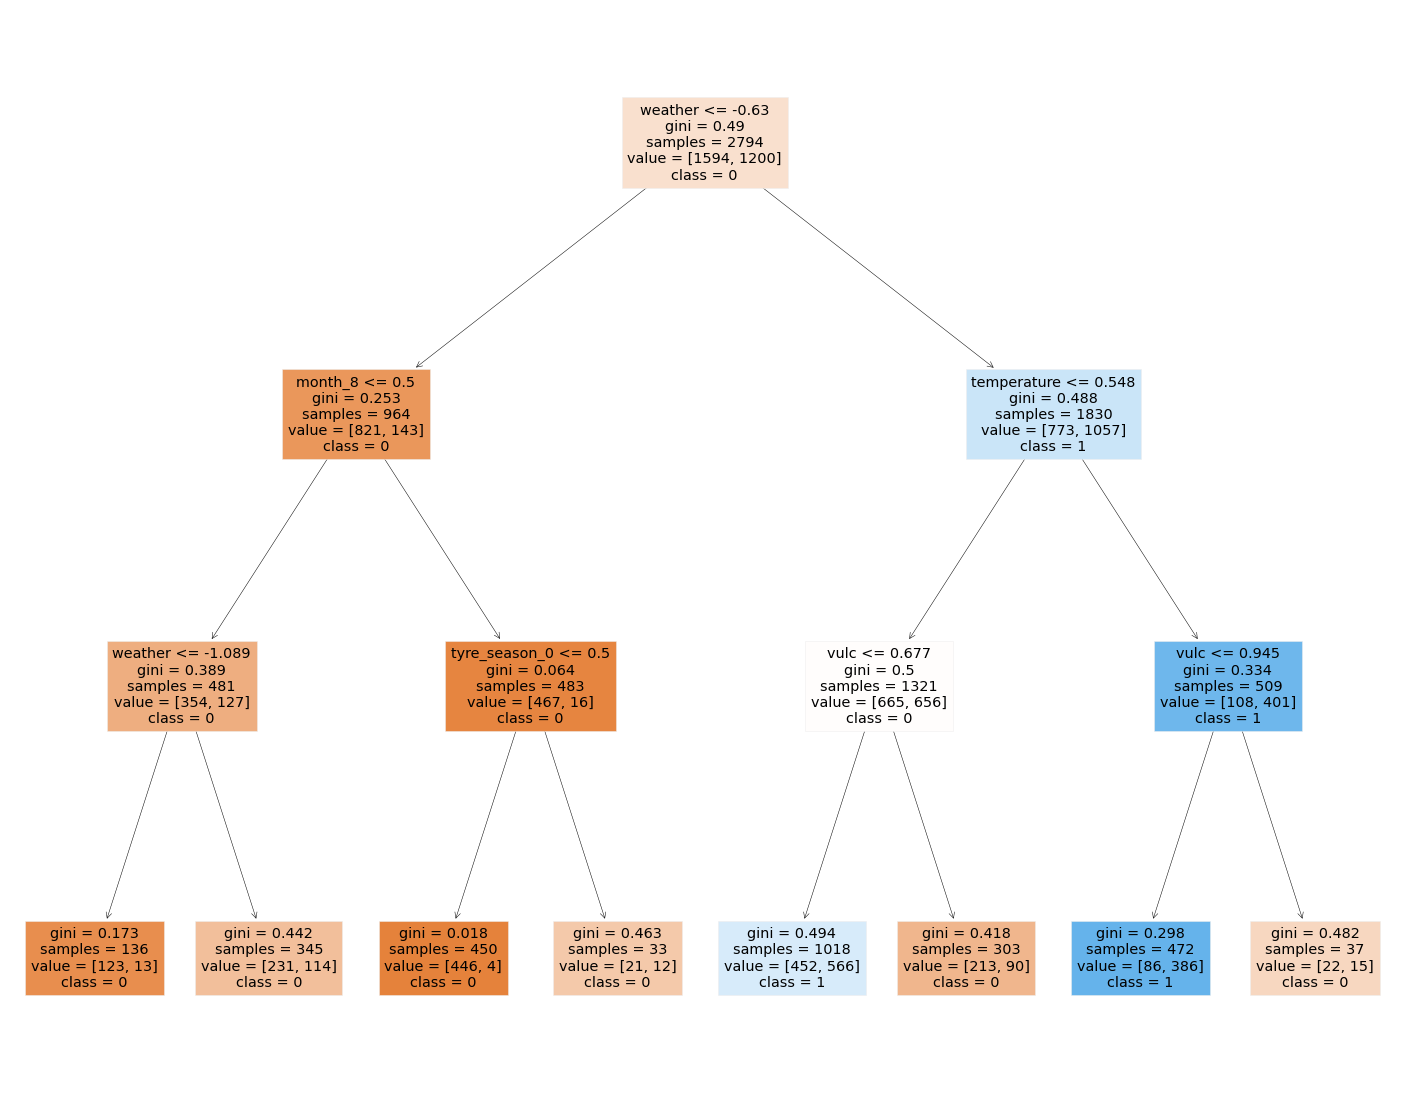

In [67]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model_Tree_over, 
                   feature_names=X_test.columns.tolist(),  
                   class_names=['0','1'],
                   filled=True)

### KNN

In [88]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(40,120,10)}


In [89]:
# no oversample
hyperp_search(classifier,parameters)

f1_train: 0.537858 using {'n_neighbors': 70}
f1         train 0.547   test 0.571
precision  train 0.699   test 0.725

[[362  36]
 [107  95]]
              precision    recall  f1-score   support

           0       0.77      0.91      0.84       398
           1       0.73      0.47      0.57       202

    accuracy                           0.76       600
   macro avg       0.75      0.69      0.70       600
weighted avg       0.76      0.76      0.75       600



In [90]:
# oversample
hyperp_search_over(classifier,parameters)

f1_train: 0.678535 using {'n_neighbors': 50}
f1         train 0.689   test 0.600
precision  train 0.718   test 0.588

[[311  87]
 [ 78 124]]
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       398
           1       0.59      0.61      0.60       202

    accuracy                           0.73       600
   macro avg       0.69      0.70      0.70       600
weighted avg       0.73      0.72      0.73       600



In [93]:
model_knn = KNeighborsClassifier(n_neighbors=70) # no oversample
model_knn_over = KNeighborsClassifier(n_neighbors=50) # oversample


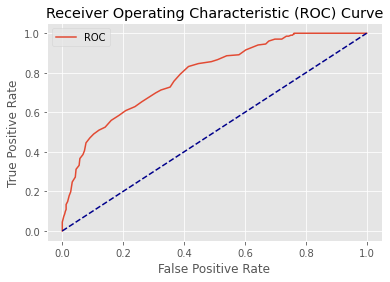

AUC: 0.79


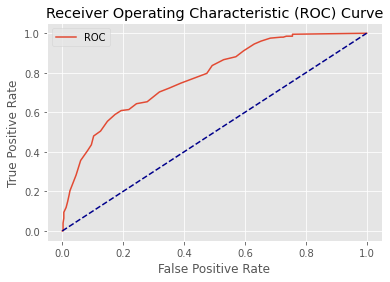

AUC: 0.78


In [94]:
#curva ROC
fpr2,tpr2=roc(model_knn,X_train,y_train,X_test,y_test) # no oversample
fpr2_over,tpr2_over=roc(model_knn_over,X2_train,y2_train,X_test,y_test) # oversample

### NAYVE BAYES

In [101]:
from sklearn.naive_bayes import GaussianNB

# no oversample
model = GaussianNB()
model.fit(X_train, y_train)
y_pred_train=model.predict(X_train)

y_pred=model.predict(X_test)

from sklearn.metrics import f1_score

print('NAYVE BAYES NO OVERSAMPLE\n\n')
print("f1_train: ", f1_score(y_train, y_pred_train))

print("f1_test: ", f1_score(y_test, y_pred))


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

NB NO OVERSAMPLE


f1_train:  0.5889212827988338
f1_test:  0.5996131528046421
[[238 160]
 [ 47 155]]
              precision    recall  f1-score   support

           0       0.84      0.60      0.70       398
           1       0.49      0.77      0.60       202

    accuracy                           0.66       600
   macro avg       0.66      0.68      0.65       600
weighted avg       0.72      0.66      0.66       600



In [102]:
# oversample

model_over = GaussianNB()
model_over.fit(X2_train, y2_train)
y_pred_train=model_over.predict(X2_train)

y_pred=model_over.predict(X_test)

print('NAYVE BAYES OVERSAMPLE\n\n')
print("f1_train: ", f1_score(y2_train, y_pred_train))

print("f1_test: ", f1_score(y_test, y_pred))


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


NB OVERSAMPLE


f1_train:  0.6647523330940416
f1_test:  0.6165703275529865
[[241 157]
 [ 42 160]]
              precision    recall  f1-score   support

           0       0.85      0.61      0.71       398
           1       0.50      0.79      0.62       202

    accuracy                           0.67       600
   macro avg       0.68      0.70      0.66       600
weighted avg       0.73      0.67      0.68       600



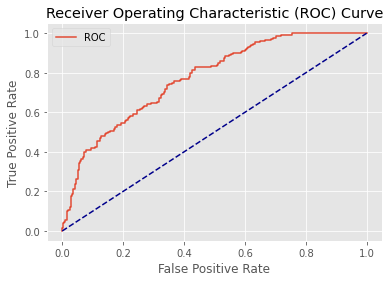

AUC: 0.77


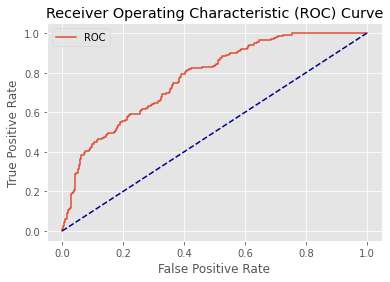

AUC: 0.77


In [103]:
#curva ROC 
fpr3,tpr3=roc(model,X_train,y_train,X_test,y_test) # no oversample
fpr3,tpr3=roc(model_over,X2_train,y2_train,X_test,y_test) # oversample

### LOGISTIC REGRESSION

In [105]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
parameters = {"C":[1e-4,1e-3,1e-2,1e-1,1,10], "penalty":['l2','none'], "max_iter":[500,1000,10000] }

In [106]:
# no oversample
hyperp_search(classifier,parameters)

f1_train: 0.562836 using {'C': 1, 'max_iter': 500, 'penalty': 'l2'}
f1         train 0.591   test 0.592
precision  train 0.680   test 0.705

[[355  43]
 [ 99 103]]
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       398
           1       0.71      0.51      0.59       202

    accuracy                           0.76       600
   macro avg       0.74      0.70      0.71       600
weighted avg       0.76      0.76      0.75       600



In [107]:
# oversample
hyperp_search_over(classifier,parameters)

f1_train: 0.668815 using {'C': 1, 'max_iter': 500, 'penalty': 'l2'}
f1         train 0.683   test 0.646
precision  train 0.704   test 0.625

[[317  81]
 [ 67 135]]
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       398
           1       0.62      0.67      0.65       202

    accuracy                           0.75       600
   macro avg       0.73      0.73      0.73       600
weighted avg       0.76      0.75      0.76       600



In [53]:
model_Log = LogisticRegression(C=1, max_iter=500,penalty='l2') # same for the one with oversample and no

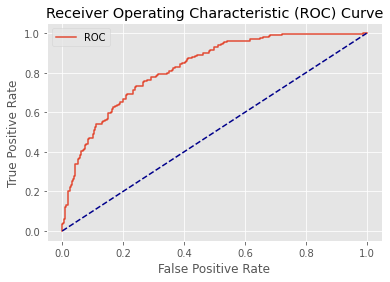

AUC: 0.82


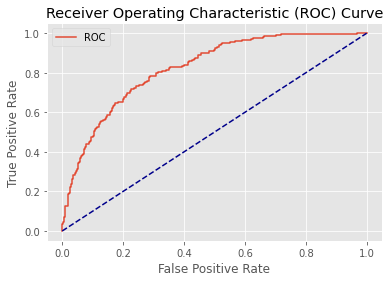

AUC: 0.82


In [108]:
#curva ROC
fpr4,tpr4=roc(model_Log,X_train,y_train,X_test,y_test) # no oversample 
fpr4,tpr4=roc(model_Log,X2_train,y2_train,X_test,y_test) # oversample

### SVM

In [111]:
from sklearn.svm import SVC

classifier = SVC()
#parameters = {"kernel":['linear','rbf','poly','sigmoid'], "C":[0.001,0.005,0.009],"gamma":[0.01,0.1,1], "degree":[1,2,3,4]}
parameters = {"kernel":['linear','rbf'], "C":[0.001,0.005,0.01, 0.05, 0.1],"gamma":[0.001, 0.01,0.1,1]}



In [112]:
# no oversample
hyperp_search(classifier,parameters)

f1_train: 0.553012 using {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
f1         train 0.563   test 0.562
precision  train 0.701   test 0.746

[[367  31]
 [111  91]]
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       398
           1       0.75      0.45      0.56       202

    accuracy                           0.76       600
   macro avg       0.76      0.69      0.70       600
weighted avg       0.76      0.76      0.74       600



In [113]:
# oversample
hyperp_search_over(classifier,parameters)

f1_train: 0.664973 using {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
f1         train 0.691   test 0.627
precision  train 0.748   test 0.630

[[324  74]
 [ 76 126]]
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       398
           1       0.63      0.62      0.63       202

    accuracy                           0.75       600
   macro avg       0.72      0.72      0.72       600
weighted avg       0.75      0.75      0.75       600



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

In [116]:
model = SVC(C=0.009, kernel='poly',degree=2,gamma=1,probability=True) # no oversample 
model_over = SVC(C = 0.1, kernel = 'rbf', degree=2, gamma=0.1, probability=True) # oversample

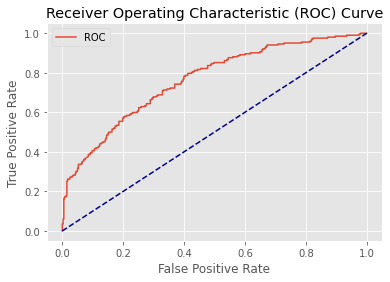

AUC: 0.76


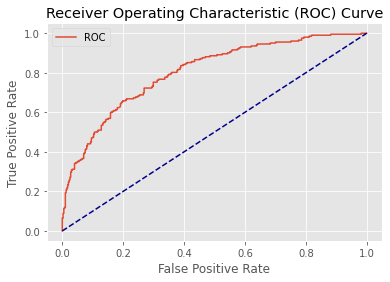

AUC: 0.80


In [117]:
fpr5,tpr5=roc(model,X_train,y_train,X_test,y_test) # no oversample
fpr5,tpr5=roc(model_over,X2_train,y2_train,X_test,y_test) # oversample

### NEURAL NETWORK

In [118]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
parameters = {"hidden_layer_sizes":[(7,5,3,2),(7,5,3),(10, 5),(10, 5,2)],  "max_iter": [1000,5000,10000], "alpha": [0.001,0.009,0.1,0.9,1]}


In [120]:
# no oversample
hyperp_search(classifier,parameters)

f1_train: 0.591313 using {'alpha': 0.9, 'hidden_layer_sizes': (10, 5), 'max_iter': 10000}
f1         train 0.663   test 0.534
precision  train 0.739   test 0.586

[[328  70]
 [103  99]]
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       398
           1       0.59      0.49      0.53       202

    accuracy                           0.71       600
   macro avg       0.67      0.66      0.66       600
weighted avg       0.70      0.71      0.70       600



In [121]:
# oversample
hyperp_search_over(classifier,parameters)

f1_train: 0.754432 using {'alpha': 0.1, 'hidden_layer_sizes': (10, 5, 2), 'max_iter': 1000}
f1         train 0.859   test 0.541
precision  train 0.846   test 0.548

[[309  89]
 [ 94 108]]
              precision    recall  f1-score   support

           0       0.77      0.78      0.77       398
           1       0.55      0.53      0.54       202

    accuracy                           0.69       600
   macro avg       0.66      0.66      0.66       600
weighted avg       0.69      0.69      0.69       600



/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_m

In [123]:
model_MLP=MLPClassifier(hidden_layer_sizes=(10,5), alpha=0.9, max_iter=10000) # no oversample
model_MLP_over=MLPClassifier(hidden_layer_sizes=(10,5,2), alpha=0.1, max_iter=1000) # oversample


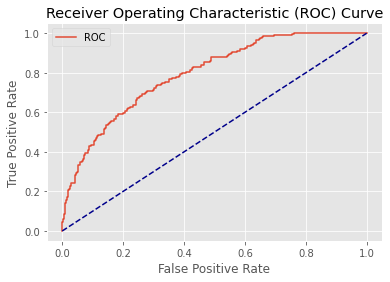

AUC: 0.79


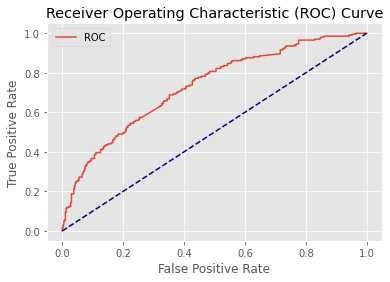

AUC: 0.73


In [124]:
#curva ROC
fpr6,tpr6=roc(model_MLP,X_train,y_train,X_test,y_test)
fpr6,tpr6=roc(model_MLP_over,X2_train,y2_train,X_test,y_test)

### RANDOM FOREST

In [125]:
from sklearn.ensemble import RandomForestClassifier


classifier= RandomForestClassifier()
parameters = {'n_estimators' :     np.arange(2,8,1),
              'criterion' :        ['entropy', 'gini'],
              'max_depth' :        np.arange(2,5,1), 
              'min_samples_split': np.arange(4,18,1),
              'min_samples_leaf' : np.arange(4,18,1),
              'class_weight' : ["balanced"]
             };



In [126]:
# no oversample
hyperp_search(classifier,parameters)

f1_train: 0.643741 using {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 7, 'min_samples_split': 6, 'n_estimators': 7}
f1         train 0.650   test 0.629
precision  train 0.531   test 0.504

[[232 166]
 [ 33 169]]
              precision    recall  f1-score   support

           0       0.88      0.58      0.70       398
           1       0.50      0.84      0.63       202

    accuracy                           0.67       600
   macro avg       0.69      0.71      0.66       600
weighted avg       0.75      0.67      0.68       600



In [127]:
# oversample
hyperp_search_over(classifier,parameters)

f1_train: 0.724437 using {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 7}
f1         train 0.730   test 0.630
precision  train 0.623   test 0.500

[[226 172]
 [ 30 172]]
              precision    recall  f1-score   support

           0       0.88      0.57      0.69       398
           1       0.50      0.85      0.63       202

    accuracy                           0.66       600
   macro avg       0.69      0.71      0.66       600
weighted avg       0.75      0.66      0.67       600



In [ ]:
model_RandomForest = RandomForestClassifier(class_weight = 'balanced',criterion='gini', max_depth=4,
                                          min_samples_leaf = 7, min_samples_split= 6, n_estimators= 7) # no oversample 
model_RandomForest_over = RandomForestClassifier(class_weight = 'balanced', criterion = 'gini', max_depth=4,
                                          min_samples_leaf = 10, min_samples_split= 15, n_estimators= 7) # oversample 



In [ ]:
#curva ROC
fpr7,tpr7=roc(model_RandomForest,X_train,y_train,X_test,y_test) # no oversample
fpr7,tpr7=roc(model_RandomForest_over,X2_train,y2_train,X_test,y_test) # oversample

# Adaboost


In [57]:
from sklearn.ensemble import AdaBoostClassifier
classifier = AdaBoostClassifier()
parameters = {'n_estimators' : [5000], 'learning_rate' : [0.01]}

#no over
hyperp_search(classifier, parameters)

f1_train: 0.571781 using {'learning_rate': 0.01, 'n_estimators': 5000}
f1         train 0.618   test 0.556
precision  train 0.685   test 0.627

[[338  60]
 [101 101]]
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       398
           1       0.63      0.50      0.56       202

    accuracy                           0.73       600
   macro avg       0.70      0.67      0.68       600
weighted avg       0.72      0.73      0.72       600



In [128]:
#oversample
hyperp_search_over(classifier, parameters)

f1_train: 0.724849 using {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 7}
f1         train 0.737   test 0.622
precision  train 0.623   test 0.484

[[210 188]
 [ 26 176]]
              precision    recall  f1-score   support

           0       0.89      0.53      0.66       398
           1       0.48      0.87      0.62       202

    accuracy                           0.64       600
   macro avg       0.69      0.70      0.64       600
weighted avg       0.75      0.64      0.65       600



# CHOICE OF THE MODEL